In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

import lsdb
#from lsdb import lsdb_client
#client = lsdb_client(dask_on_ray=False, num_workers=12)

In [6]:
import tape

In [7]:
tape.__version__

'0.2.5.dev46+g4db6f6a'

In [2]:
#client.client

In [8]:
%%time
# Load gaia object table
gaia = lsdb.read_hipscat("/data3/epyc/data3/hipscat/test_catalogs/gaia_symbolic")

# Load ZTF object table
ztf = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 source table
ztf_src = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

# load ZTF zubercal source table
ztf_zuber_sources = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/zubercal")

CPU times: user 20min 15s, sys: 31.1 s, total: 20min 46s
Wall time: 20min 52s


In [91]:
len(ztf_src._ddf.get_partition(1_000))

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 30.43 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


2253109

In [94]:
%%time
len(ztf_sources._ddf.get_partition(1_000))

KeyboardInterrupt: 

In [9]:
# ztf_src # inspect ztf_src

In [10]:
# ztf_sources # inspect ztf_source ZUBERCAL!!

### Goals
Here we will show a simple demo of using LSDB quick crossmatching and TAPE for processing light curves. Our goal will be to build a Gaia CMD and compute a few time-series features.

### Cone-Searching

In [11]:
%%time
ra, dec = 132, 5
rad = 3 # in degrees
_sample = gaia.cone_search(
    ra=ra,
    dec=dec,
    radius=rad,
).crossmatch(
    ztf
).query(
    "nobs_g_ztf_dr14 > 250 and nobs_r_ztf_dr14 > 250 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 10 and \
    classprob_dsc_combmod_star_gaia > 0.9"
).compute()

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

CPU times: user 23.1 s, sys: 30.2 s, total: 53.2 s
Wall time: 12.2 s


In [12]:
%%time
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _sample, 
    lowest_order=5, 
    highest_order=8, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

CPU times: user 963 ms, sys: 46 ms, total: 1.01 s
Wall time: 1.08 s


In [13]:
%%time
ss = _sample_hips.join(
    ztf_zubercal_sources, left_on="ps1_objid_ztf_dr14", right_on="objectid")

CPU times: user 620 ms, sys: 26 ms, total: 646 ms
Wall time: 646 ms


In [14]:
# DO NOT EXECUTE!!!
# join tables to final ZTF source list (i.e photometry)
#_sample_sources = _sample_hips.join(
#    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="objectid"
#).compute()

In [16]:
ztf_sources._ddf.head(3) # zubercal source table

,mjd,mag,objdec,objra,magerr,objectid,info,flag,rcidin,fieldid,band,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,
11756634112,58466.280479,17.960501,0.00548,44.995949,1625,108000449961107213,67108864,0,55,402,g,5,0,0
11760828416,59629.197791,18.408100,0.00547,44.996120,1190,108000449961107213,0,0,55,402,g,5,0,0
11765022720,58718.482734,17.607901,0.00561,44.996140,206,108000449961107213,0,0,55,402,r,5,0,0


In [17]:
ztf._ddf.head(3) # ztf object table

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,
12490637312,108000449961107213,44.996152,0.005626,18.113300,17.627800,17.406500,364,381,18,18.143208,17.569102,17.373423,3,0,0
98125742080,108020450140974134,45.014110,0.019775,21.565901,21.134199,21.414301,42,114,1,21.298568,21.007693,20.599543,3,0,0
104371060736,108010450069569645,45.007042,0.015954,22.047899,21.641199,21.655001,5,17,0,21.552179,21.405765,NaN,3,0,0


In [18]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

In [19]:
# Initialize an Ensemble
ens = Ensemble(memory_limit=1e11)
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37573 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37573/status,
Dashboard: http://127.0.0.1:37573/status,Workers: 12
Total threads: 96,Total memory: 1.09 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43523,Workers: 12
Dashboard: http://127.0.0.1:37573/status,Total threads: 96
Started: Just now,Total memory: 1.09 TiB
Comm: tcp://127.0.0.1:39013,Total threads: 8
Dashboard: http://127.0.0.1:37499/status,Memory: 93.13 GiB
Nanny: tcp://127.0.0.1:43507,


In [ ]:
len(ens.object)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 26.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-12-12 16:51:01,854 - distributed.dashboard.components.scheduler - ERROR - 'str' object has no attribute 'text'
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/utils.py", line 838, in wrapper
    return func(*args, **kwargs)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/dashboard/components/scheduler.py", line 434, in update
    self.root.title.text = title
AttributeError: 'str' object has no attribute 'text'
2023-12-12 16:51:01,857 - distributed.dashboard.components.scheduler - ERROR - 'str' object has no attribute 'text'
Traceback (most recent call last):
  File "/epyc/users/atzani

2023-12-12 16:51:22,537 - distributed.dashboard.components.scheduler - ERROR - 'str' object has no attribute 'text'
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/utils.py", line 838, in wrapper
    return func(*args, **kwargs)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/dashboard/components/scheduler.py", line 434, in update
    self.root.title.text = title
AttributeError: 'str' object has no attribute 'text'
2023-12-12 16:51:22,540 - distributed.dashboard.components.scheduler - ERROR - 'str' object has no attribute 'text'
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/utils.py", line 838, in wrapper
    return func(*args, **kwargs)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/dashboard/components/sched

2023-12-12 16:51:42,934 - distributed.dashboard.components.scheduler - ERROR - 'str' object has no attribute 'text'
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/utils.py", line 838, in wrapper
    return func(*args, **kwargs)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/dashboard/components/scheduler.py", line 4727, in status_doc
    cluster_memory.update()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/core/property/validation.py", line 95, in func
    return input_function(*args, **kwargs)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/utils.py", line 838, in wrapper
    return func(*args, **kwargs)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/dashboard/components/scheduler.py", line 434, 

In [20]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index', # TODO: need to confirm if this is okay...!
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

In [21]:
%%time
# We can read from parquet
ens.from_dask_dataframe(
    source_frame=ss._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

CPU times: user 113 ms, sys: 28.8 ms, total: 142 ms
Wall time: 135 ms


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


In [23]:
ens.source # check 

,solution_id_gaia_,designation_gaia_,source_id_gaia_,random_index_gaia_,ref_epoch_gaia_,ra_gaia_,ra_error_gaia_,dec_gaia_,dec_error_gaia_,parallax_gaia_,parallax_error_gaia_,parallax_over_error_gaia_,pm_gaia_,pmra_gaia_,pmra_error_gaia_,pmdec_gaia_,pmdec_error_gaia_,ra_dec_corr_gaia_,ra_parallax_corr_gaia_,ra_pmra_corr_gaia_,ra_pmdec_corr_gaia_,dec_parallax_corr_gaia_,dec_pmra_corr_gaia_,dec_pmdec_corr_gaia_,parallax_pmra_corr_gaia_,parallax_pmdec_corr_gaia_,pmra_pmdec_corr_gaia_,astrometric_n_obs_al_gaia_,astrometric_n_obs_ac_gaia_,astrometric_n_good_obs_al_gaia_,astrometric_n_bad_obs_al_gaia_,astrometric_gof_al_gaia_,astrometric_chi2_al_gaia_,astrometric_excess_noise_gaia_,astrometric_excess_noise_sig_gaia_,astrometric_params_solved_gaia_,astrometric_primary_flag_gaia_,nu_eff_used_in_astrometry_gaia_,pseudocolour_gaia_,pseudocolour_error_gaia_,ra_pseudocolour_corr_gaia_,dec_pseudocolour_corr_gaia_,parallax_pseudocolour_corr_gaia_,pmra_pseudocolour_corr_gaia_,pmdec_pseudocolour_corr_gaia_,astrometric_matched_transits_gaia_,visibility_periods_used_gaia_,astrometric_sigma5d_max_gaia_,matched_transits_gaia_,new_matched_transits_gaia_,matched_transits_removed_gaia_,ipd_gof_harmonic_amplitude_gaia_,ipd_gof_harmonic_phase_gaia_,ipd_frac_multi_peak_gaia_,ipd_frac_odd_win_gaia_,ruwe_gaia_,scan_direction_strength_k1_gaia_,scan_direction_strength_k2_gaia_,scan_direction_strength_k3_gaia_,scan_direction_strength_k4_gaia_,scan_direction_mean_k1_gaia_,scan_direction_mean_k2_gaia_,scan_direction_mean_k3_gaia_,scan_direction_mean_k4_gaia_,duplicated_source_gaia_,phot_g_n_obs_gaia_,phot_g_mean_flux_gaia_,phot_g_mean_flux_error_gaia_,phot_g_mean_flux_over_error_gaia_,phot_g_mean_mag_gaia_,phot_bp_n_obs_gaia_,phot_bp_mean_flux_gaia_,phot_bp_mean_flux_error_gaia_,phot_bp_mean_flux_over_error_gaia_,phot_bp_mean_mag_gaia_,phot_rp_n_obs_gaia_,phot_rp_mean_flux_gaia_,phot_rp_mean_flux_error_gaia_,phot_rp_mean_flux_over_error_gaia_,phot_rp_mean_mag_gaia_,phot_bp_rp_excess_factor_gaia_,phot_bp_n_contaminated_transits_gaia_,phot_bp_n_blended_transits_gaia_,phot_rp_n_contaminated_transits_gaia_,phot_rp_n_blended_transits_gaia_,phot_proc_mode_gaia_,bp_rp_gaia_,bp_g_gaia_,g_rp_gaia_,radial_velocity_gaia_,radial_velocity_error_gaia_,rv_method_used_gaia_,rv_nb_transits_gaia_,rv_nb_deblended_transits_gaia_,rv_visibility_periods_used_gaia_,rv_expected_sig_to_noise_gaia_,rv_renormalised_gof_gaia_,rv_chisq_pvalue_gaia_,rv_time_duration_gaia_,rv_amplitude_robust_gaia_,rv_template_teff_gaia_,rv_template_logg_gaia_,rv_template_fe_h_gaia_,rv_atm_param_origin_gaia_,vbroad_gaia_,vbroad_error_gaia_,vbroad_nb_transits_gaia_,grvs_mag_gaia_,grvs_mag_error_gaia_,grvs_mag_nb_transits_gaia_,rvs_spec_sig_to_noise_gaia_,phot_variable_flag_gaia_,l_gaia_,b_gaia_,ecl_lon_gaia_,ecl_lat_gaia_,in_qso_candidates_gaia_,in_galaxy_candidates_gaia_,non_single_star_gaia_,has_xp_continuous_gaia_,has_xp_sampled_gaia_,has_rvs_gaia_,has_epoch_photometry_gaia_,has_epoch_rv_gaia_,has_mcmc_gspphot_gaia_,has_mcmc_msc_gaia_,in_andromeda_survey_gaia_,classprob_dsc_combmod_quasar_gaia_,classprob_dsc_combmod_galaxy_gaia_,classprob_dsc_combmod_star_gaia_,teff_gspphot_gaia_,teff_gspphot_lower_gaia_,teff_gspphot_upper_gaia_,logg_gspphot_gaia_,logg_gspphot_lower_gaia_,logg_gspphot_upper_gaia_,mh_gspphot_gaia_,mh_gspphot_lower_gaia_,mh_gspphot_upper_gaia_,distance_gspphot_gaia_,distance_gspphot_lower_gaia_,distance_gspphot_upper_gaia_,azero_gspphot_gaia_,azero_gspphot_lower_gaia_,azero_gspphot_upper_gaia_,ag_gspphot_gaia_,ag_gspphot_lower_gaia_,ag_gspphot_upper_gaia_,ebpminrp_gspphot_gaia_,ebpminrp_gspphot_lower_gaia_,ebpminrp_gspphot_upper_gaia_,libname_gspphot_gaia_,Norder_gaia_,Npix_gaia_,Dir_gaia_,ps1_objid_ztf_dr14_,ra_ztf_dr14_,dec_ztf_dr14_,ps1_gMeanPSFMag_ztf_dr14_,ps1_rMeanPSFMag_ztf_dr14_,ps1_iMeanPSFMag_ztf_dr14_,nobs_g_ztf_dr14_,nobs_r_ztf_dr14_,nobs_i_ztf_dr14_,mean_mag_g_ztf_dr14_,mean_mag_r_ztf_dr14_,mean_mag_i_ztf_dr14_,Norder_ztf_dr14_,Dir_ztf_dr14_,Npix_ztf_dr14_,_DIST_,Norder_,Dir_,Np

In [24]:
import astropy.stats as astro_stats

def deviation(mag, mag_err):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    R, S = astro_stats.biweight_location(mag), astro_stats.biweight_scale(mag)

    return (mag - R) / np.sqrt(mag_err**2 + S**2)


def frac_above_dev(dev):
    """Calculate the fraction of detections above 2 sigma from the deviation"""
    M = np.median(dev)
    # fraction above 2-sigma from the M
    two_sig = M + 2*np.std(dev)
    
    if len(dev)>0:
        return len(dev[dev>two_sig])/len(dev)
    else:
        return 0


def assymetry_yso_M(mag):
    """Calculate the magnitude assymetry score defined by Hillenbrand et al. 2022 (https://iopscience.iop.org/article/10.3847/1538-3881/ac62d8/pdf).

    Described in the paper: 
    Objects that have M values <0 are predominately brightening,
    objects with M values >0 are predominantly dimming, and
    objects with M values near 0 have symmetric light curves.

    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    
    Returns:
    --------
    assymetry (float): Assymetry score.
    """
    
    if len(mag)>0:
        mag_decile = np.percentile(mag, 10)

        return (mag_decile - np.nanmedian(mag))/np.nanstd(mag)
    else:
        return 0

In [25]:
# output columns
output_cols = ["median", "frac_dev", "M_stat"]

# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=output_cols, dtype=float)

def calc_biweight_lc(time, mag, mag_err, flag, band):
    """custom function"""
    rmv = (flag == 0) & (band=='r')
    
    time, mag, mag_err, flag, band = time[rmv], mag[rmv], mag_err[rmv], flag[rmv], band[rmv]
    
    # sort times
    xs = np.argsort(time)
    
    time, mag, mag_err, flag = time[xs], mag[xs], mag_err[xs], flag[xs]
    
    # compute features
    _f = frac_above_dev(deviation(mag, mag_err))
    _M = assymetry_yso_M(mag)
    
    return pd.Series([np.median(mag), _f, _M],
                     index=output_cols)


In [26]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    calc_biweight_lc,
    'mjd_zubercal', 'mag_zubercal', 'magerr_zubercal', 'flag_zubercal','band_zubercal',
    meta=my_meta,
    use_map=True, 
    compute=False
)

Using generated label, result_1, for a batch result.
CPU times: user 17.9 ms, sys: 9.91 ms, total: 27.8 ms
Wall time: 25.3 ms


In [27]:
#%%time
#calc_.compute()

In [28]:
ens.assign(table='object', 
            median=calc_['median'], 
            frac_dev=calc_['frac_dev'], 
            M_stat=calc_['M_stat'])

In [73]:
ens.object.head(3) # check if they are on object table...

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,Norder,Dir,Npix,median,frac_dev,M_stat
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
1155824212435271680,1636148068921376768,Gaia DR3 577912077587977984,577912077587977984,1189065986,2016.0,133.244697,0.012343,2.385606,0.006730,1.182077,...,3,0,64,0.000019,5,0,1026,12.764900,0.012371,-0.429252
1155770790298255360,1636148068921376768,Gaia DR3 577885380071452032,577885380071452032,804661708,2016.0,133.075056,0.018500,2.199635,0.010848,0.812521,...,3,0,64,0.000026,5,0,1026,14.341900,0.032990,-0.961071
1155771284089470976,1636148068921376768,Gaia DR3 577885620589619072,577885620589619072,1656062966,2016.0,133.072029,0.031036,2.224451,0.017411,0.811010,...,3,0,64,0.000024,5,0,1026,15.531549,0.014403,-1.094456


In [74]:
ens.object.head(3)['ps1_objid_ztf_dr14']

_hipscat_index
1155824212435271680    110861332447193165
1155770790298255360    110641330750290039
1155771284089470976    110661330720189804
Name: ps1_objid_ztf_dr14, dtype: int64

In [76]:
# let's work with the following: 
# hipscat_index: 1155770790298255360
# ps1_id: 110641330750290039

In [77]:
%%time
# use the above hipscat_index... and retreive source....
lc = ens.source.loc[1155770790298255360]

CPU times: user 10.8 ms, sys: 961 µs, total: 11.7 ms
Wall time: 11 ms


In [78]:
lc

,solution_id_gaia_,designation_gaia_,source_id_gaia_,random_index_gaia_,ref_epoch_gaia_,ra_gaia_,ra_error_gaia_,dec_gaia_,dec_error_gaia_,parallax_gaia_,parallax_error_gaia_,parallax_over_error_gaia_,pm_gaia_,pmra_gaia_,pmra_error_gaia_,pmdec_gaia_,pmdec_error_gaia_,ra_dec_corr_gaia_,ra_parallax_corr_gaia_,ra_pmra_corr_gaia_,ra_pmdec_corr_gaia_,dec_parallax_corr_gaia_,dec_pmra_corr_gaia_,dec_pmdec_corr_gaia_,parallax_pmra_corr_gaia_,parallax_pmdec_corr_gaia_,pmra_pmdec_corr_gaia_,astrometric_n_obs_al_gaia_,astrometric_n_obs_ac_gaia_,astrometric_n_good_obs_al_gaia_,astrometric_n_bad_obs_al_gaia_,astrometric_gof_al_gaia_,astrometric_chi2_al_gaia_,astrometric_excess_noise_gaia_,astrometric_excess_noise_sig_gaia_,astrometric_params_solved_gaia_,astrometric_primary_flag_gaia_,nu_eff_used_in_astrometry_gaia_,pseudocolour_gaia_,pseudocolour_error_gaia_,ra_pseudocolour_corr_gaia_,dec_pseudocolour_corr_gaia_,parallax_pseudocolour_corr_gaia_,pmra_pseudocolour_corr_gaia_,pmdec_pseudocolour_corr_gaia_,astrometric_matched_transits_gaia_,visibility_periods_used_gaia_,astrometric_sigma5d_max_gaia_,matched_transits_gaia_,new_matched_transits_gaia_,matched_transits_removed_gaia_,ipd_gof_harmonic_amplitude_gaia_,ipd_gof_harmonic_phase_gaia_,ipd_frac_multi_peak_gaia_,ipd_frac_odd_win_gaia_,ruwe_gaia_,scan_direction_strength_k1_gaia_,scan_direction_strength_k2_gaia_,scan_direction_strength_k3_gaia_,scan_direction_strength_k4_gaia_,scan_direction_mean_k1_gaia_,scan_direction_mean_k2_gaia_,scan_direction_mean_k3_gaia_,scan_direction_mean_k4_gaia_,duplicated_source_gaia_,phot_g_n_obs_gaia_,phot_g_mean_flux_gaia_,phot_g_mean_flux_error_gaia_,phot_g_mean_flux_over_error_gaia_,phot_g_mean_mag_gaia_,phot_bp_n_obs_gaia_,phot_bp_mean_flux_gaia_,phot_bp_mean_flux_error_gaia_,phot_bp_mean_flux_over_error_gaia_,phot_bp_mean_mag_gaia_,phot_rp_n_obs_gaia_,phot_rp_mean_flux_gaia_,phot_rp_mean_flux_error_gaia_,phot_rp_mean_flux_over_error_gaia_,phot_rp_mean_mag_gaia_,phot_bp_rp_excess_factor_gaia_,phot_bp_n_contaminated_transits_gaia_,phot_bp_n_blended_transits_gaia_,phot_rp_n_contaminated_transits_gaia_,phot_rp_n_blended_transits_gaia_,phot_proc_mode_gaia_,bp_rp_gaia_,bp_g_gaia_,g_rp_gaia_,radial_velocity_gaia_,radial_velocity_error_gaia_,rv_method_used_gaia_,rv_nb_transits_gaia_,rv_nb_deblended_transits_gaia_,rv_visibility_periods_used_gaia_,rv_expected_sig_to_noise_gaia_,rv_renormalised_gof_gaia_,rv_chisq_pvalue_gaia_,rv_time_duration_gaia_,rv_amplitude_robust_gaia_,rv_template_teff_gaia_,rv_template_logg_gaia_,rv_template_fe_h_gaia_,rv_atm_param_origin_gaia_,vbroad_gaia_,vbroad_error_gaia_,vbroad_nb_transits_gaia_,grvs_mag_gaia_,grvs_mag_error_gaia_,grvs_mag_nb_transits_gaia_,rvs_spec_sig_to_noise_gaia_,phot_variable_flag_gaia_,l_gaia_,b_gaia_,ecl_lon_gaia_,ecl_lat_gaia_,in_qso_candidates_gaia_,in_galaxy_candidates_gaia_,non_single_star_gaia_,has_xp_continuous_gaia_,has_xp_sampled_gaia_,has_rvs_gaia_,has_epoch_photometry_gaia_,has_epoch_rv_gaia_,has_mcmc_gspphot_gaia_,has_mcmc_msc_gaia_,in_andromeda_survey_gaia_,classprob_dsc_combmod_quasar_gaia_,classprob_dsc_combmod_galaxy_gaia_,classprob_dsc_combmod_star_gaia_,teff_gspphot_gaia_,teff_gspphot_lower_gaia_,teff_gspphot_upper_gaia_,logg_gspphot_gaia_,logg_gspphot_lower_gaia_,logg_gspphot_upper_gaia_,mh_gspphot_gaia_,mh_gspphot_lower_gaia_,mh_gspphot_upper_gaia_,distance_gspphot_gaia_,distance_gspphot_lower_gaia_,distance_gspphot_upper_gaia_,azero_gspphot_gaia_,azero_gspphot_lower_gaia_,azero_gspphot_upper_gaia_,ag_gspphot_gaia_,ag_gspphot_lower_gaia_,ag_gspphot_upper_gaia_,ebpminrp_gspphot_gaia_,ebpminrp_gspphot_lower_gaia_,ebpminrp_gspphot_upper_gaia_,libname_gspphot_gaia_,Norder_gaia_,Npix_gaia_,Dir_gaia_,ps1_objid_ztf_dr14_,ra_ztf_dr14_,dec_ztf_dr14_,ps1_gMeanPSFMag_ztf_dr14_,ps1_rMeanPSFMag_ztf_dr14_,ps1_iMeanPSFMag_ztf_dr14_,nobs_g_ztf_dr14_,nobs_r_ztf_dr14_,nobs_i_ztf_dr14_,mean_mag_g_ztf_dr14_,mean_mag_r_ztf_dr14_,mean_mag_i_ztf_dr14_,Norder_ztf_dr14_,Dir_ztf_dr14_,Npix_ztf_dr14_,_DIST_,Norder_,Dir_,Np

In [79]:
%%time 
lcc = lc.compute()

CPU times: user 8.64 s, sys: 2.7 s, total: 11.3 s
Wall time: 11.5 s


Text(0, 0.5, 'mag')

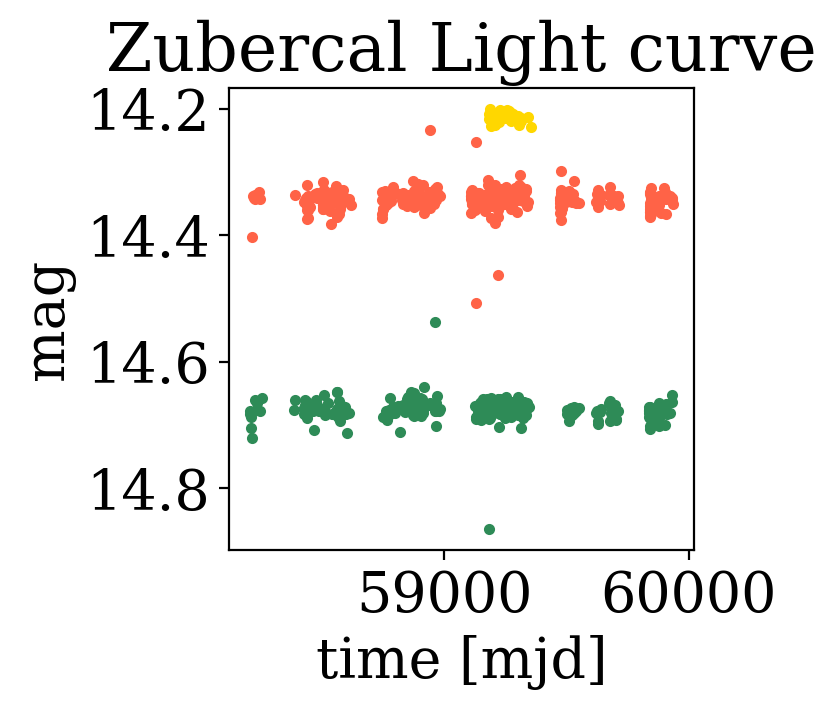

In [80]:
plt.figure(figsize=(3,3))
for flt, clr in zip(list('gri'), ['seagreen', 'tomato', 'gold']):
    ff = lcc['band_zubercal']==flt
    
    plt.errorbar(lcc['mjd_zubercal'][ff], lcc['mag_zubercal'][ff], fmt='.' ,color=clr)
    # magerr_zubercal: TODO: SOMETHING wrong...
plt.title("Zubercal Light curve")
plt.ylim(plt.ylim()[::-1])
plt.xlabel("time [mjd]")
plt.ylabel("mag")

In [81]:
# Now we want to investigate the same source in ZTF DR14 source...

In [82]:
# Initialize an Ensemble
ens2 = Ensemble(memory_limit=1e11)
ens2.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34673 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34673/status,
Dashboard: http://127.0.0.1:34673/status,Workers: 12
Total threads: 96,Total memory: 1.09 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45956,Workers: 12
Dashboard: http://127.0.0.1:34673/status,Total threads: 96
Started: Just now,Total memory: 1.09 TiB
Comm: tcp://127.0.0.1:46107,Total threads: 8
Dashboard: http://127.0.0.1:45223/status,Memory: 93.13 GiB
Nanny: tcp://127.0.0.1:46260,


In [83]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap2 = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )
# We can read from parquet
ens2.from_dask_dataframe(
    source_frame=ztf_src._ddf,
    object_frame=_sample_hips._ddf.copy(),
    column_mapper=colmap2,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


In [63]:
#ens2.object.head(3)['ps1_objid_ztf_dr14']

_hipscat_index
1155824212435271680    110861332447193165
1155770790298255360    110641330750290039
1155771284089470976    110661330720189804
Name: ps1_objid_ztf_dr14, dtype: int64

In [84]:
obj_insp = ens2.object.query("ps1_objid_ztf_dr14==110641330750290039")

In [85]:
obj_insp.head(5)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:8260: UserWarning: Insufficient elements for `head`. 5 elements requested, only 1 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
1155770790298255360,1636148068921376768,Gaia DR3 577885380071452032,577885380071452032,804661708,2016.0,133.075056,0.0185,2.199635,0.010848,0.812521,...,14.690012,14.297646,14.175921,3,0,64,0.000026,5,0,1026


In [86]:
%%time
test = (ens2.source.loc[1155770790298255360]).compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 30.43 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 5.48 s, sys: 2.79 s, total: 8.27 s
Wall time: 6.57 s


In [87]:
test

,index,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,...,catflags,fieldID,mag,magerr,mjd,rcID,band,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
1155770790298255360,22307,110641330750290039,133.075082,2.199632,14.6738,14.3371,14.2187,285,444,29,...,0,465,14.689126,0.011156,59150.50702,1,g,6,0,4106


In [37]:
new = ztf_src._ddf.query("ps1_objid==110861332447193165")

In [39]:
%%time
test = new.compute()

Task exception was never retrieved
future: <Task finished name='Task-20730' coro=<Client._gather.<locals>.wait() done, defined at /epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-20731' coro=<Client._gather.<locals>.wait() done, defined at /epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finishe

CPU times: user 4.13 s, sys: 775 ms, total: 4.91 s
Wall time: 8.01 s


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:8260: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


In [41]:
# Initialize an Ensemble
ens2 = Ensemble(memory_limit=1e11)
ens2.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37372 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37372/status,
Dashboard: http://127.0.0.1:37372/status,Workers: 12
Total threads: 96,Total memory: 1.09 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44897,Workers: 12
Dashboard: http://127.0.0.1:37372/status,Total threads: 96
Started: Just now,Total memory: 1.09 TiB
Comm: tcp://127.0.0.1:45185,Total threads: 8
Dashboard: http://127.0.0.1:44556/status,Memory: 93.13 GiB
Nanny: tcp://127.0.0.1:44732,


In [44]:
obj_insp = ens2.object.query("ps1_objid==110861332447193165")

In [ ]:
obj_indp.head(5)

In [ ]:
ens2.source.loc[]

In [46]:
# t = new_test.compute() BAD!

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 30.43 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-12-12 15:28:56,797 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('query-9155a10842f871e6570c7098eb87241f', 191419))" coro=<Worker.execute() done, defined at /epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker_state_machine.py:3610>> ended with CancelledError
2023-12-12 15:28:56,798 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('query-9155a10842f871e6570c7098eb87241f', 165755))" coro=<Worker.execute() done, defined at /epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker_state_machine.py:3610>> ended with CancelledError
2023-

    if cb(*exc_details):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/contextlib.py", line 449, in _exit_wrapper
    callback(*args, **kwds)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/threading.py", line 1100, in join
    self._wait_for_tstate_lock(timeout=max(timeout, 0))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/threading.py", line 1116, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
KeyboardInterrupt
2023-12-12 15:28:56,929 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('query-9155a10842f871e6570c7098eb87241f', 88063))" coro=<Worker.execute() done, defined at /epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/worker_state_machine.py:3610>> ended with CancelledError
2023-12-12 15:28:56,930 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute

  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/selectors.py", line 469, in select
    fd_event_list = self._selector.poll(timeout, max_ev)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/nanny.py", line 988, in _run
    with contextlib.ExitStack() as stack:
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/compatibility.py", line 236, in asyncio_run
    return loop.run_until_complete(main)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/contextlib.py", line 576, in __exit__
    raise exc_details[1]
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    self.run_forever()
  File "/epyc/users/atzanida

In [49]:
%%time
stat_table = calc_.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 217.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: Runt

/tmp/ipykernel_58430/3943818868.py:57: RuntimeWarning: invalid value encountered in scalar divide
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divi

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divi

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divi

CPU times: user 1min 41s, sys: 50.8 s, total: 2min 32s
Wall time: 4min 4s


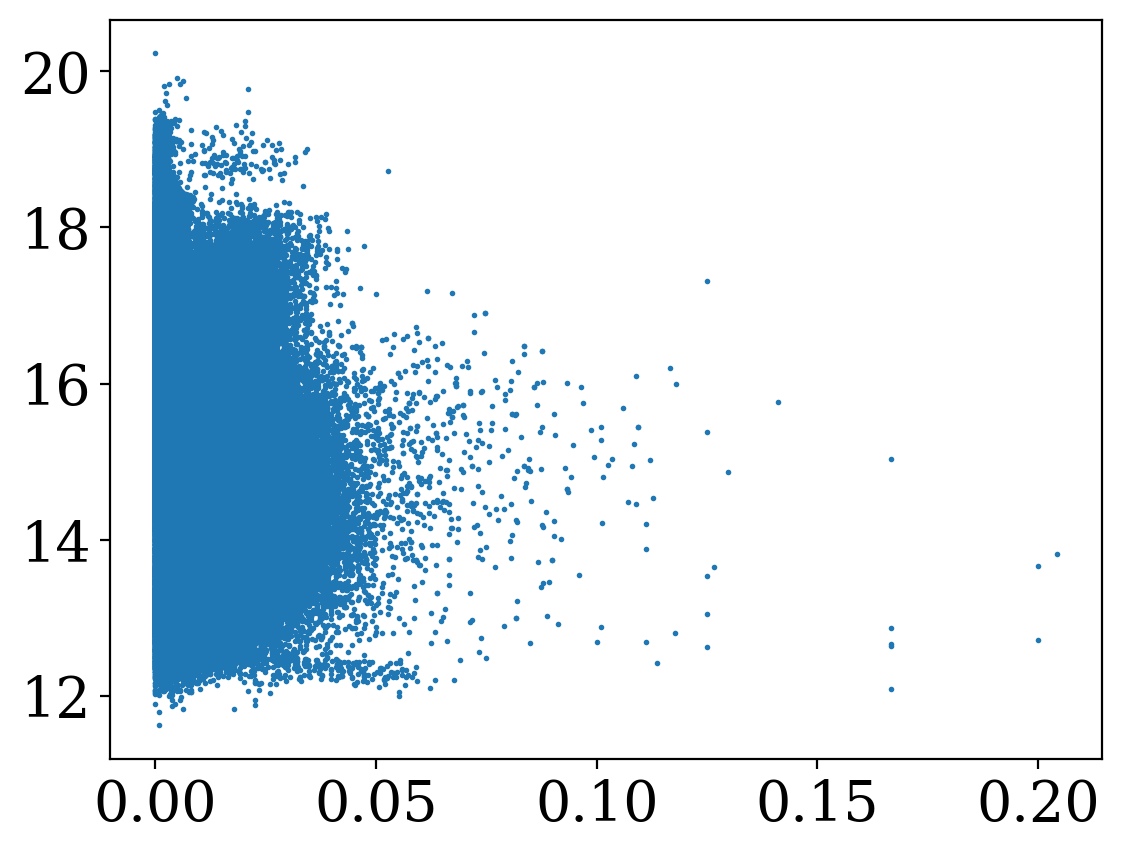

In [51]:
plt.scatter(stat_table['frac_dev'], stat_table['median'], s=1)

Text(0.5, 0, 'M$_{var}$')

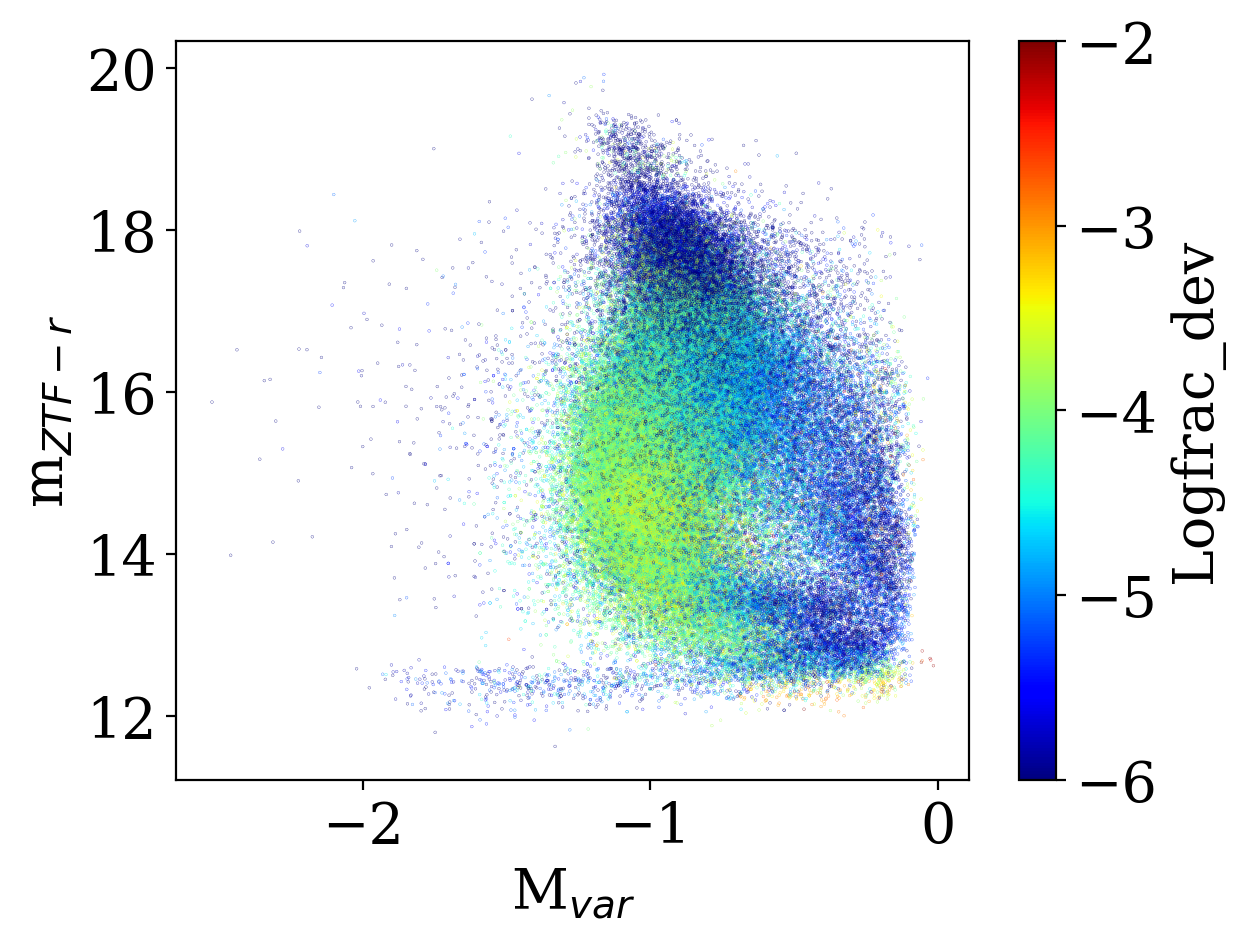

In [61]:
plt.scatter(stat_table['M_stat'], stat_table['median'], s=0.01, c=np.log(stat_table['frac_dev']), 
           cmap='jet', vmin=-6, vmax=-2)
plt.colorbar(label="Logfrac_dev")
plt.ylabel("m$_{ZTF-r}$")
plt.xlabel("M$_{var}$")

## Fetch Light curves with extreme M

In [70]:
sindex = (stat_table['M_stat']>-0.1) & (stat_table['frac_dev']>0.1)

In [71]:
stat_table[sindex]

,median,frac_dev,M_stat
_hipscat_index,,,
6179266249441148928,12.7998,0.117647,-0.054276
6179268950971383808,12.6592,0.166667,-0.057343
6179763842155806720,12.7066,0.200000,-0.026846
6179950786877849600,12.6171,0.125000,-0.015401


In [72]:
%%time
src_table = ens._source.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 217.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 8min 31s, sys: 25min 14s, total: 33min 45s
Wall time: 31min 22s


AttributeError: 'Ensemble' object has no attribute 'source'